<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DBSCAN vs. K-Means

_Author: Katie Sylvia_
 
 In **Unsupervised Learning** we have different type of algorithms such as:
 
1. Clustering
2. PCA
2. Association Rules
3. Recommendation Engines


In **Clustering** we have talked about:
1. K-Means Clustering
2. DBSCAN Clustering

In this notebook, we will mainly discuss *DBSCAN Clustering*

As you recall from yesterday, there are some disadvantages in K-Means Clustering. Among them are that K-Means is sensitive to outliers and does not perform well with non-spherical shapes of clusters.
   
   To deal with this we have *Density Based Spatial Clustering (DBSCAN)*:
   
     - It is mainly used to find outliers and to deal with non-spherical data
     - Clustering is mainly done based on density of data points (where more number of data points are present).


In [1]:
# Something new to install...
#! pip install plotly

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Something new to import...
import plotly.express as px

# Imports from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans

# Setting formatting of floats to be five places past the decimal
pd.options.display.float_format = '{:.5f}'.format

### I. Get Data Ready

In [3]:
# From Plotly, we'll import the Gapminder data
df = px.data.gapminder()

In [4]:
# Head
df.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.80100,8425333,779.44531,AFG,4
1,Afghanistan,Asia,1957,30.33200,9240934,820.85303,AFG,4
2,Afghanistan,Asia,1962,31.99700,10267083,853.10071,AFG,4
3,Afghanistan,Asia,1967,34.02000,11537966,836.19714,AFG,4
4,Afghanistan,Asia,1972,36.08800,13079460,739.98111,AFG,4


In [5]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1704 non-null   object 
 1   continent  1704 non-null   object 
 2   year       1704 non-null   int64  
 3   lifeExp    1704 non-null   float64
 4   pop        1704 non-null   int64  
 5   gdpPercap  1704 non-null   float64
 6   iso_alpha  1704 non-null   object 
 7   iso_num    1704 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 106.6+ KB


In [6]:
# Nulls
df.isnull().sum()

country      0
continent    0
year         0
lifeExp      0
pop          0
gdpPercap    0
iso_alpha    0
iso_num      0
dtype: int64

In [7]:
# Filter Data to Most Recent Year
df['year'].value_counts()

1952    142
1957    142
1962    142
1967    142
1972    142
1977    142
1982    142
1987    142
1992    142
1997    142
2002    142
2007    142
Name: year, dtype: int64

In [8]:
# Filter Data to Most Recent Year
df_recent = df[df['year']==2007]
df_recent.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
11,Afghanistan,Asia,2007,43.82800,31889923,974.58034,AFG,4
23,Albania,Europe,2007,76.42300,3600523,5937.02953,ALB,8
35,Algeria,Africa,2007,72.30100,33333216,6223.36747,DZA,12
47,Angola,Africa,2007,42.73100,12420476,4797.23127,AGO,24
59,Argentina,Americas,2007,75.32000,40301927,12779.37964,ARG,32


In [9]:
# Set Country to Index
df_recent.set_index(['country'],drop=True,inplace=True)

In [10]:
# Check the result from set index
df_recent.head()

,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
country,,,,,,,
Afghanistan,Asia,2007,43.82800,31889923,974.58034,AFG,4
Albania,Europe,2007,76.42300,3600523,5937.02953,ALB,8
Algeria,Africa,2007,72.30100,33333216,6223.36747,DZA,12
Angola,Africa,2007,42.73100,12420476,4797.23127,AGO,24
Argentina,Americas,2007,75.32000,40301927,12779.37964,ARG,32


In [11]:
# Drop `iso_alpha`, `year`, and `iso_num`
df_recent = df_recent.drop(columns=['year', 'iso_alpha','iso_num'])
df_recent.head()

,continent,lifeExp,pop,gdpPercap
country,,,,
Afghanistan,Asia,43.82800,31889923,974.58034
Albania,Europe,76.42300,3600523,5937.02953
Algeria,Africa,72.30100,33333216,6223.36747
Angola,Africa,42.73100,12420476,4797.23127
Argentina,Americas,75.32000,40301927,12779.37964


In [12]:
# How many countries in each continent?
df_recent.groupby(['continent']).count()['pop']

continent
Africa      52
Americas    25
Asia        33
Europe      30
Oceania      2
Name: pop, dtype: int64

In [13]:
# Get dummies!
df_recent = pd.get_dummies(df_recent, 
                           columns=['continent'], 
                           drop_first=True)

In [14]:
# Head (again!)
df_recent.head()

,lifeExp,pop,gdpPercap,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
country,,,,,,,
Afghanistan,43.82800,31889923,974.58034,0,1,0,0
Albania,76.42300,3600523,5937.02953,0,0,1,0
Algeria,72.30100,33333216,6223.36747,0,0,0,0
Angola,42.73100,12420476,4797.23127,0,0,0,0
Argentina,75.32000,40301927,12779.37964,1,0,0,0


In [15]:
# Define X

X = df_recent

In [16]:
# Scale Features
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

### II. K-Means Clustering Model

In [17]:
# Elbow Plot

inertia_list = []

for k in range(1, 21):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia_list.append(km.inertia_)

inertia_list

[993.9999999999999,
 745.3298363925305,
 574.4502741562058,
 411.73669924060437,
 265.0727010035231,
 145.1814036102372,
 107.71312813400925,
 85.04751469619288,
 64.21503964722277,
 51.117630191621906,
 44.427393449311325,
 39.613916380431505,
 34.9732936272792,
 33.18665046027544,
 30.359278762662246,
 27.639949575351263,
 25.090287961160275,
 22.98909666475644,
 20.760694556571327,
 18.799312136382866]

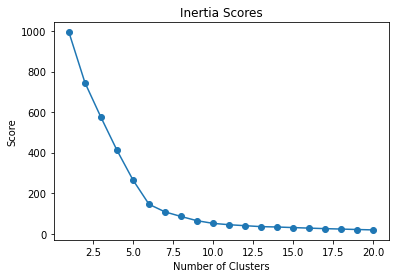

In [18]:
# Inertia score
plt.plot(range(1,21), inertia_list, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Inertia Scores");

In [19]:
# Silhouette Score

silhouette_list = []

for k in range(2, 21):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    silhouette_list.append(silhouette_score(X_scaled, km.labels_))

silhouette_list

[0.37364650802336946,
 0.4487356234240466,
 0.5626593043305045,
 0.6010799129127454,
 0.6350842772929556,
 0.639081463196919,
 0.593693718907387,
 0.5983706823621519,
 0.6055705819165501,
 0.570938799570904,
 0.532980577767962,
 0.5348277074522618,
 0.5318705449299053,
 0.5299561901678386,
 0.4900023949230819,
 0.5030706386561817,
 0.47671262362019773,
 0.47008471719963224,
 0.4717557647961839]

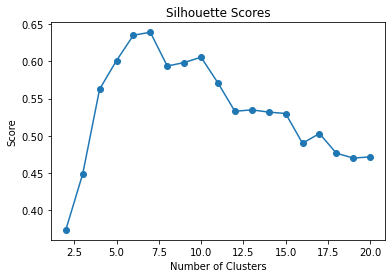

In [20]:
plt.plot(range(2,21),silhouette_list, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Silhouette Scores");

#### Based off of our metrics above, which k should we try first?

Answer Here: We should try k equal to 6.



In [21]:
# Now let's try it!

# Instantiate & Fit
km = KMeans(n_clusters=6, random_state=42)
km.fit(X_scaled)

KMeans(n_clusters=6, random_state=42)

In [22]:
# Silhouette Score
silhouette_score(X_scaled, km.labels_)

0.6350842772929556

#### Visualize Your Clusters!

In [23]:
# Add cluster column
df_recent['cluster'] = km.labels_
X['cluster'] = km.labels_

In [24]:
df_recent.columns

Index(['lifeExp', 'pop', 'gdpPercap', 'continent_Americas', 'continent_Asia',
       'continent_Europe', 'continent_Oceania', 'cluster'],
      dtype='object')

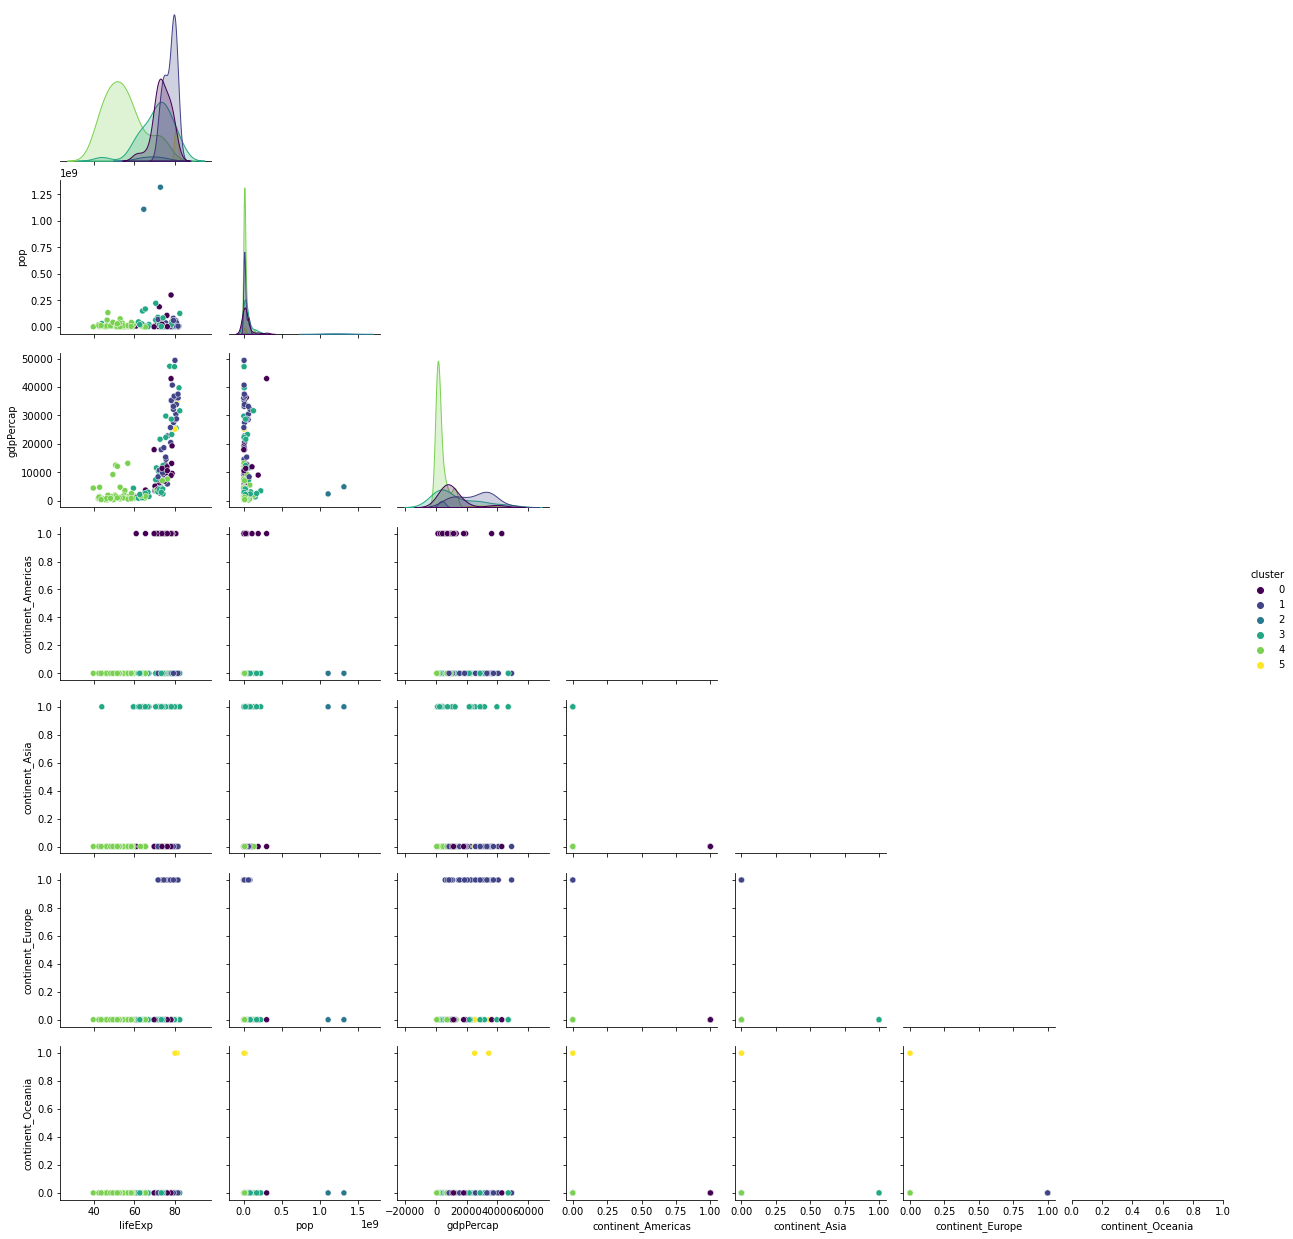

In [25]:
# Method 1: Pairplots/Scatterplots
sns.pairplot(df_recent, 
             corner=True, 
             hue='cluster',
             palette='viridis' );

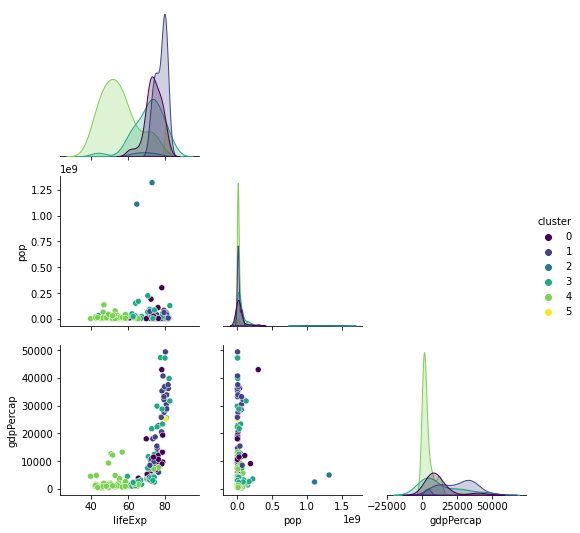

In [26]:
# Method 1: Pairplots/Scatterplots (2)
sns.pairplot(df_recent[['lifeExp', 'pop', 'gdpPercap','cluster']], 
             corner=True, 
             hue='cluster',
             palette='viridis' );

In [27]:
# Method 2: Groupby
df_recent.groupby(['cluster']).aggregate(['mean','count'])[['lifeExp','pop','gdpPercap']].T


cluster                      0              1                2              3  \
lifeExp   mean        73.60812       77.64860         68.82950       70.85100   
          count       25.00000       30.00000          2.00000       31.00000   
pop       mean  35954847.36000 19536617.63333 1214539713.50000 44608851.61290   
          count       25.00000       30.00000          2.00000       31.00000   
gdpPercap mean     11003.03163    25054.48164       3705.66263    13038.66327   
          count       25.00000       30.00000          2.00000       31.00000   

cluster                      4              5  
lifeExp   mean        54.80604       80.71950  
          count       52.00000        2.00000  
pop       mean  17875763.30769 12274973.50000  
          count       52.00000        2.00000  
gdpPercap mean      3089.03260    29810.18827  
          count       52.00000        2.00000

#### An Even Closer Look...Which countries are in each of these clusters?

In [28]:
# For loop
country = []
for i in range(6):
    country.append(list(df_recent[df_recent['cluster']==i].index))
    print(f'Cluster{i}: {country[i]}\n')

Cluster0: ['Argentina', 'Bolivia', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Puerto Rico', 'Trinidad and Tobago', 'United States', 'Uruguay', 'Venezuela']

Cluster1: ['Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom']

Cluster2: ['China', 'India']

Cluster3: ['Afghanistan', 'Bahrain', 'Bangladesh', 'Cambodia', 'Hong Kong, China', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Korea, Dem. Rep.', 'Korea, Rep.', 'Kuwait', 'Lebanon', 'Malaysia', 'Mongolia', 'Myanmar', 'Nepal', 'Oman', 'Pakistan', 'Ph

### III. [In Groups] DBSCAN Clustering Model

- Try tuning your parameters
- Visualize your clusters
- Determine your best silhouette score
- Is this better or worse than KMeans?
- Which countries are in each cluster?

In [29]:
# Try tuning your parameters
epsilon_list = [0.4, 0.5, 1, 1.5, 1.7, 2, 2.3, 2.7 ,3, 5, 8]
score_list = []
for eps in epsilon_list:
    # Instantiate
    dbscan = DBSCAN(eps=eps)

    # Fit or train
    dbscan.fit(X_scaled)
    
    # score
    score_list.append(silhouette_score(X_scaled, dbscan.labels_))

In [30]:
# Silhouette scores at various epsilons
results = pd.DataFrame(data=score_list, 
                       columns=['Silhouette Score'],
                       index = epsilon_list)
results

,Silhouette Score
0.40000,0.31782
0.50000,0.42827
1.00000,0.60344
1.50000,0.60980
1.70000,0.60980
2.00000,0.61064
2.30000,0.61064
2.70000,0.64868
3.00000,0.64868
5.00000,0.64868


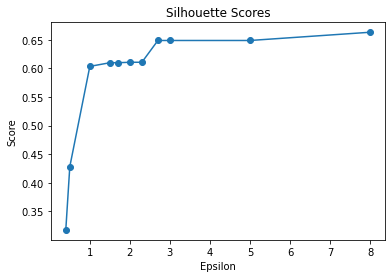

In [31]:
# Determine your best silhouette score. -> epsilon=1
plt.plot(epsilon_list, score_list, marker='o')
plt.xlabel("Epsilon")
plt.ylabel("Score")
plt.title("Silhouette Scores");

In [32]:
dbscan = DBSCAN(eps=1)
dbscan.fit(X_scaled)
df_recent['cluster'] = dbscan.labels_

In [33]:
df_recent['cluster'].value_counts()

 1    52
 0    30
 3    30
 2    23
-1     7
Name: cluster, dtype: int64

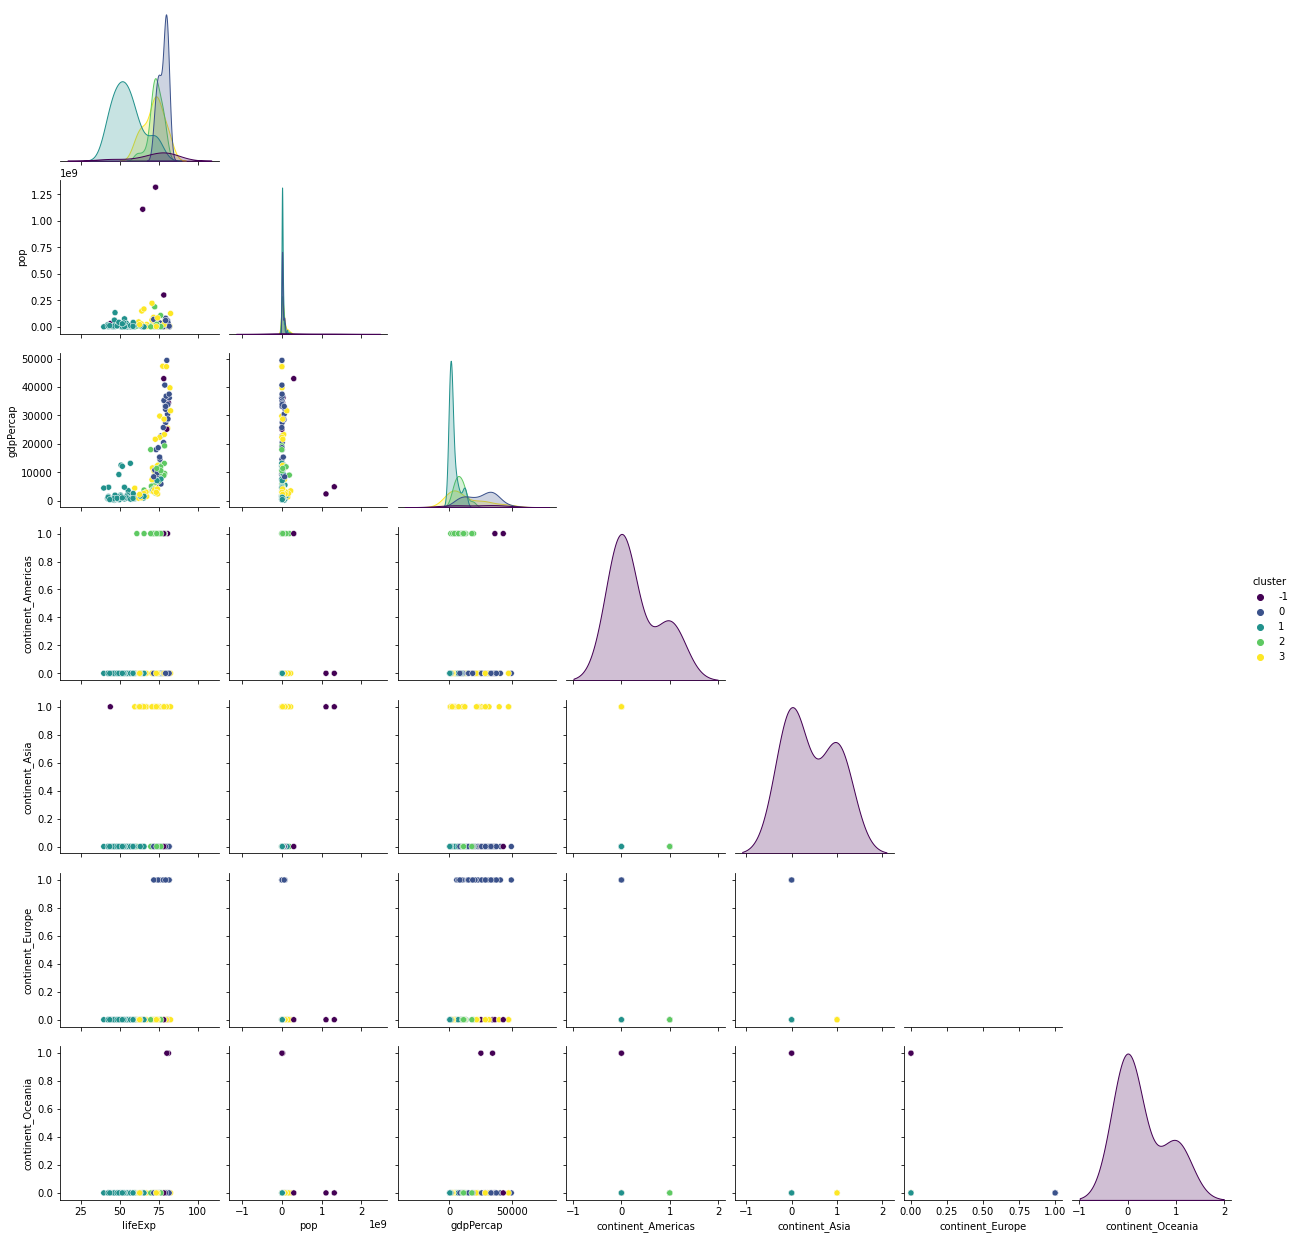

In [34]:
# Visualize your clusters
# Pairplots/Scatterplots
sns.pairplot(df_recent, 
             corner=True, 
             hue='cluster',
             palette='viridis');

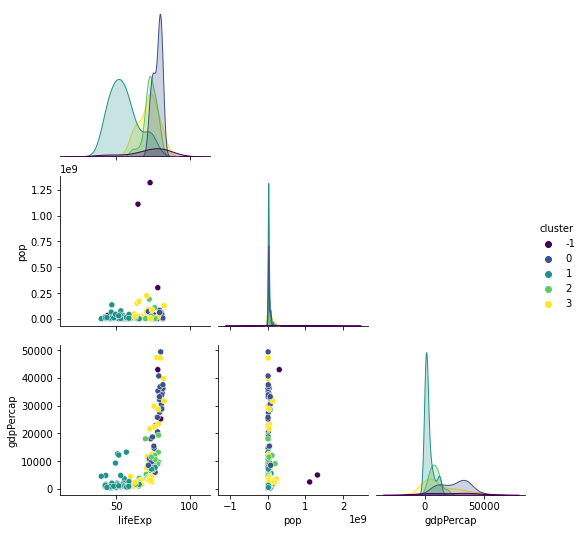

In [35]:
# Pairplots/Scatterplots (2)
sns.pairplot(df_recent[['lifeExp', 'pop', 'gdpPercap','cluster']], 
             corner=True, 
             hue='cluster',
             palette='viridis' );

In [ ]:
# Is this better or worse than KMeans? It's worse than KMeans.

In [37]:
df_recent['cluster'].value_counts()

 1    52
 0    30
 3    30
 2    23
-1     7
Name: cluster, dtype: int64

In [38]:
# Which countries are in each cluster?
country = []
for i in [-1,0,1,2,3]:
    country.append(list(df_recent[df_recent['cluster']==i].index))
    print(f'Cluster{i}: {country[i+1]}\n')

Cluster-1: ['Afghanistan', 'Australia', 'Canada', 'China', 'India', 'New Zealand', 'United States']

Cluster0: ['Albania', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom']

Cluster1: ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Reunion', 'Rwanda', 'Sao Tome and Principe', 'Sene

### ⭐ There are pros & cons for both DBSCAN and K-Means Clustering Models. Again, since this is unsupervised it is not easy to know which method you should use until you dive into your data! Keep exploring and diving into your data 💫 